In [ ]:
# Standard library
import os
import re
import sys
import warnings
from pathlib import Path

# Third-party - Data and scientific computing
import contextily as cx
import geopandas as gpd
import igraph as ig
import numpy as np
import pandas as pd
from pyproj import Geod
from tqdm import tqdm

# Shapely-specific imports for spatial analysis
import shapely
from shapely import STRtree
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import nearest_points, snap

# Matplotlib-specific imports for figures
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [ ]:
data_path = Path('input_files')
figure_path = Path('figures')
intermediate_path = Path('intermediate_results')

In [ ]:
gdf_hazards = gpd.read_parquet(intermediate_path / "main_network_hazard_exposure.parquet") 
base_network = gpd.read_parquet(intermediate_path / 'PERS_directed_final.parquet')

In [ ]:
hospital_exposed_edges = gpd.read_parquet(intermediate_path / 'hospital_impacts.parquet').to_crs(gdf_hazards.crs)
factory_exposed_edges = gpd.read_parquet(intermediate_path / 'factory_impacts.parquet').to_crs(gdf_hazards.crs)
police_exposed_edges = gpd.read_parquet(intermediate_path / 'police_impacts.parquet').to_crs(gdf_hazards.crs)
fire_exposed_edges = gpd.read_parquet(intermediate_path / 'fire_impacts.parquet').to_crs(gdf_hazards.crs)

In [ ]:
# Ensure gdf_hazards has a stable index to aggregate on
gdf_hazards = gdf_hazards.copy()
gdf_hazards.index.name = 'hazard_id'  # name the index for clarity

def add_impact_column(base_gdf, edges_gdf, impact_col_name, predicate="intersects", agg="mean"):
    """
    Spatially join edges to base_gdf, aggregate travel_time_impact per base index, and add as a new column.
    - predicate: 'intersects', 'within', 'contains', 'touches' (choose based on geometry semantics)
    - agg: 'mean', 'max', 'min', 'median' etc.
    """
    # Keep only needed columns to avoid bloat
    edges = edges_gdf[['travel_time_impact', 'geometry']].copy()

    # Spatial join (left frame is base), this creates potential many-to-one matches
    joined = base_gdf.sjoin(edges, how='left', predicate=predicate)

    # Aggregate per left index (hazard_id)
    # Note: joined.index is the left index; the sjoin adds right index as 'index_right'
    agg_series = joined.groupby(joined.index)['travel_time_impact'].agg(agg)

    # Attach to base_gdf with a clear name
    base_gdf[impact_col_name] = agg_series.reindex(base_gdf.index)

    return base_gdf

# Add each impact column (choose your aggregator: 'mean' or 'max')
gdf_hazards = add_impact_column(gdf_hazards, hospital_exposed_edges, 'hospital_impact', predicate='intersects', agg='mean')
gdf_hazards = add_impact_column(gdf_hazards, factory_exposed_edges,  'factory_impact',  predicate='intersects', agg='mean')
gdf_hazards = add_impact_column(gdf_hazards, police_exposed_edges,   'police_impact',   predicate='intersects', agg='mean')
gdf_hazards = add_impact_column(gdf_hazards, fire_exposed_edges,     'fire_impact',     predicate='intersects', agg='mean')

# Optional: replace NaN (no intersecting edges) with 0 hours or leave as NaN
gdf_hazards[['hospital_impact','factory_impact','police_impact','fire_impact']] = \
    gdf_hazards[['hospital_impact','factory_impact','police_impact','fire_impact']].fillna(np.nan)

# Quick sanity checks
print(gdf_hazards[['hospital_impact','factory_impact','police_impact','fire_impact']].describe())


       hospital_impact  factory_impact  police_impact  fire_impact
count      1352.000000      498.000000    1349.000000  1362.000000
mean          0.511585        1.284271       0.539098     0.536650
std           0.208209        1.451149       0.207785     0.210733
min           0.167864        0.177675       0.167785     0.167696
25%           0.361753        0.328879       0.374569     0.378934
50%           0.478612        0.549458       0.530302     0.504705
75%           0.601792        2.010024       0.679469     0.669450
max           1.247413        7.962391       1.113554     1.086346


In [ ]:
gdf_hazards = gdf_hazards.rename(columns = {'max_depth' : 'flood_depth', 
                              'dužina_sn' : 'snow_drift', 
                              'datum_evid' : 'landslide_date', 
                              'hospital_impact' : 'hospital_delay',
                               'factory_impact' : 'factory_delay', 
                              'police_impact' : 'police_delay',
                              'fire_impact' : 'fire_delay'})

In [ ]:
gdf_hazards

,oznaka_deo,smer_gdf1,kategorija,oznaka_put,oznaka_poc,naziv_poce,oznaka_zav,naziv_zavr,duzina_deo,pocetna_st,...,road_length,average_time_disruption,vhl,flood_depth,snow_drift,landslide_date,hospital_delay,factory_delay,police_delay,fire_delay
hazard_id,,,,,,,,,,,,,,,,,,,,,
4,A1023,D,IA,A1,A111,petlja Novi Sad sever,A112,petlja Novi Sad centar,1.661,110.231,...,1.663877,0.057215,683.146321,1.663,NaN,None,NaN,NaN,NaN,NaN
6,A1004,L,IA,A1,A102,petlja Subotica sever,A101,petlja Horgoš,12.607,16.844,...,5.364673,0.001360,10.733231,1.000,NaN,None,NaN,NaN,NaN,NaN
10,A1024,L,IA,A1,A112,petlja Novi Sad centar,A111,petlja Novi Sad sever,1.654,111.892,...,1.652847,0.012194,145.598159,1.663,NaN,None,0.236584,0.717213,0.285780,0.271364
13,A1006,L,IA,A1,A103,petlja Subotica istok,A102,petlja Subotica sever,6.311,23.140,...,5.716745,0.000883,8.662728,1.000,3.00,None,NaN,NaN,NaN,NaN
23,A1009,D,IA,A1,A104,petlja Subotica jug,A105,petlja Žednik,11.090,26.600,...,10.516662,0.002592,31.130705,1.793,NaN,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4861,None,None,None,A1,dA16003,None,dA16004,None,NaN,NaN,...,0.289380,0.141341,771.806612,1.577,NaN,None,NaN,NaN,NaN,NaN
4865,None,None,None,A1,dA16102,None,dA16103,None,NaN,NaN,...,0.271521,0.003459,21.189198,NaN,1.25,None,NaN,NaN,NaN,NaN
4869,None,None,None,A1,dA14902,None,dA14903,None,NaN,NaN,...,0.399442,0.010700,116.137273,1.372,NaN,None,0.211912,NaN,0.310633,0.279813


In [ ]:
# Columns after your rename
hazard_cols = ['flood_depth', 'snow_drift', 'landslide_date']            # hazard exposure
delay_cols  = ['vhl','hospital_delay', 'factory_delay', 'police_delay', 'fire_delay']  # service delays

# 1) Prepare inputs
gdf_hazards = gdf_hazards.copy()

# If landslide_date is a string date, convert to a presence indicator [0,1]
# 1 if there is a date present, else 0. If you prefer to ignore landslides, skip this step and remove from hazard_cols.
gdf_hazards['landslide_presence'] = np.where(gdf_hazards['landslide_date'].astype(str).str.len() > 0, 1.0, 0.0)

# Choose which columns to normalize
cols_to_normalize = ['flood_depth', 'snow_drift', 'landslide_presence'] + delay_cols

# Ensure columns exist and fill NaNs with 0
for c in cols_to_normalize:
    if c not in gdf_hazards.columns:
        gdf_hazards[c] = 0.0
    gdf_hazards[c] = gdf_hazards[c].astype(float).fillna(0.0)

# 2) Safe min–max normalization to [0, 1]
def safe_minmax(s):
    s = s.astype(float)
    s = s.fillna(0.0)
    min_v = s.min()
    max_v = s.max()
    if pd.isna(min_v) or pd.isna(max_v) or max_v == min_v:
        # constant or all zeros, return zeros
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - min_v) / (max_v - min_v)

for c in cols_to_normalize:
    gdf_hazards[f'{c}_norm'] = safe_minmax(gdf_hazards[c])

# 3) Build aggregate criticality
# Option A simple unweighted average across normalized hazards and delays
norm_hazards = ['flood_depth_norm', 'snow_drift_norm', 'landslide_presence_norm']
norm_delays  = [f'{c}_norm' for c in delay_cols]
all_norm     = norm_hazards + norm_delays

# Simple average
gdf_hazards['criticality_sum'] = gdf_hazards[all_norm].sum(axis=1)

In [ ]:
gdf_hazards[['hospital_delay', 'factory_delay', 'police_delay', 'fire_delay']] = gdf_hazards[['hospital_delay', 'factory_delay', 'police_delay', 'fire_delay']]*60

In [ ]:
gdf_hazards.to_excel(intermediate_path / 'VUA_Climate_Criticality_PERS.xlsx')

In [ ]:
gdf_hazards.sort_values('criticality_sum',ascending=False)

,oznaka_deo,smer_gdf1,kategorija,oznaka_put,oznaka_poc,naziv_poce,oznaka_zav,naziv_zavr,duzina_deo,pocetna_st,...,landslide_presence,flood_depth_norm,snow_drift_norm,landslide_presence_norm,vhl_norm,hospital_delay_norm,factory_delay_norm,police_delay_norm,fire_delay_norm,criticality_sum
hazard_id,,,,,,,,,,,,,,,,,,,,,
1264,25902,O,IIA,259,25901,Niš (Niška Banja),25902,Crvena Reka,21.460,2.033,...,1.0,1.000000,0.358816,0.0,0.028340,0.463946,0.050827,0.779858,0.792683,3.474469
3806,25902,O,IIA,259,25901,Niš (Niška Banja),25902,Crvena Reka,21.460,2.033,...,1.0,1.000000,0.358816,0.0,0.004927,0.463946,0.050827,0.779858,0.792683,3.451056
696,02330,O,IB,23,2328,Prijepolje,2329,Kolovrat,5.134,233.405,...,1.0,0.284339,0.000000,0.0,0.177481,0.902573,0.000000,1.000000,1.000000,3.364392
4606,20101,O,IIA,201,2134,Sjenica,20101,granica SRB/CG (Vrbnica),41.302,0.000,...,1.0,0.465062,1.000000,0.0,0.039118,0.543416,0.000000,0.610181,0.623760,3.281537
1997,33801,O,IIB,338,17001,Sedlari,17401,Varda,45.540,0.000,...,1.0,0.000000,0.791660,0.0,0.027335,0.784233,0.000000,0.760865,0.910960,3.275052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3353,02710,O,IB,27,2709,Ose?ina (Osladi?),2710,Donja Kamenica,10.126,48.187,...,1.0,0.000000,0.000000,0.0,0.000080,0.000000,0.000000,0.000000,0.000000,0.000080
3761,17101,O,IIA,171,2806,Dub,17002,Bajina BaŠta (Dub),12.847,0.000,...,1.0,0.000000,0.000000,0.0,0.000047,0.000000,0.000000,0.000000,0.000000,0.000047
3784,18302,O,IIA,183,18301,Gornja Sabanta,18302,Rekovac,11.044,16.493,...,1.0,0.000000,0.000000,0.0,0.000041,0.000000,0.000000,0.000000,0.000000,0.000041


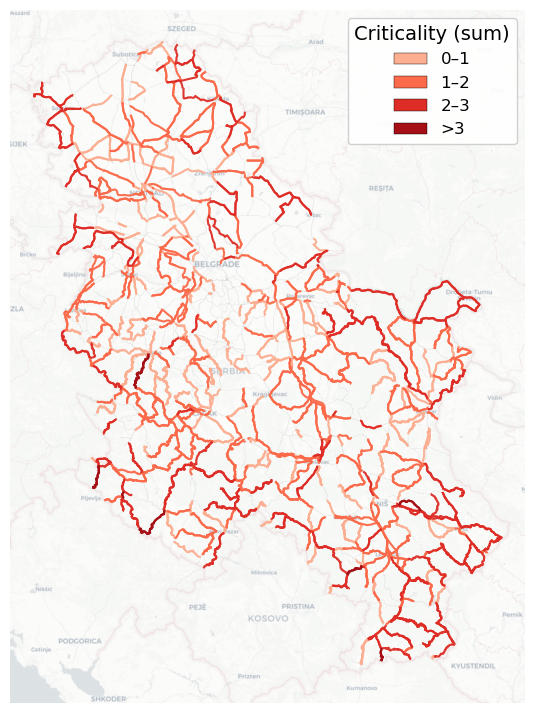

In [ ]:
# 1) Prepare data: drop zero or missing criticality
gdf_plot = gdf_hazards.copy().to_crs(3857)
gdf_plot = gdf_plot[gdf_plot['criticality_sum'].fillna(0) > 0.1]

# 2) Define bins and labels
bins = [0, 1, 2, 3, np.inf]
labels = ['0–1', '1–2', '2–3', '>3']

# 3) Assign classes
gdf_plot['criticality_class'] = pd.cut(
    gdf_plot['criticality_sum'],
    bins=bins,
    labels=labels,
    include_lowest=False,  # (0–1], (1–2], (2–3], (3, inf)
    right=True
)

# 4) Colors (low to high) — swap to your preferred palette if needed
colors = ['#fcae91','#fb6a4a','#de2d26','#a50f15']
color_map = dict(zip(labels, colors))

# 5) Figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 9), facecolor='white')

# Base network (light grey) — plotted above basemap, below criticality
base_network.to_crs(3857).plot(ax=ax, linewidth=0.15, color='lightgrey', alpha=0.6, zorder=2)

# Plot each class
for cls in labels:
    sub = gdf_plot[gdf_plot['criticality_class'] == cls]
    if len(sub) == 0:
        continue
    sub.plot(
        ax=ax,
        color=color_map[cls],
        linewidth=1.5,
        alpha=0.95,
        zorder=4
    )

# Legend
legend_handles = [
    Patch(facecolor=color_map[lbl], edgecolor='black', linewidth=0.3, label=lbl)
    for lbl in labels
]
ax.legend(
    handles=legend_handles,
    title='Criticality (sum)',
    loc='upper right',
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    fontsize=12,
    title_fontsize=14
)

cx.add_basemap(
    ax=ax,
    source=cx.providers.CartoDB.Positron,
    alpha=0.8,       # light background
    attribution=False,
    zorder=1)


# Cosmetics
ax.set_aspect('equal')
ax.axis('off')


plt.savefig(figure_path / 'criticality_sum_map.png', dpi=300, bbox_inches='tight')


In [ ]:
# --- Settings ---
TOP_METHOD = "quantile"    # "quantile" or "topN" or "cutoff"
TOP_Q = 0.90               # top 10% by criticality_sum
TOP_N = 1000               # if TOP_METHOD == "topN"
CUTOFF_VAL = 3.0           # if TOP_METHOD == "cutoff" (e.g., >3 in your legend)

# --- Prep ---
gdf = gdf_hazards.copy()

gdf["len_km"] = gdf['road_length']

# Identify normalized submetrics used in the sum
norm_cols = sorted([c for c in gdf.columns if c.endswith("_norm")])
if "criticality_sum" not in gdf.columns:
    # If not present, create it as sum of all _norm columns
    gdf["criticality_sum"] = gdf[norm_cols].sum(axis=1)

# --- Select top critical segments ---
if TOP_METHOD == "quantile":
    thr = gdf["criticality_sum"].quantile(TOP_Q)
    top_mask = gdf["criticality_sum"] >= thr
elif TOP_METHOD == "topN":
    top_idx = gdf["criticality_sum"].nlargest(TOP_N).index
    top_mask = gdf.index.isin(top_idx)
elif TOP_METHOD == "cutoff":
    top_mask = gdf["criticality_sum"] > CUTOFF_VAL
else:
    raise ValueError("TOP_METHOD must be one of: quantile, topN, cutoff")

top = gdf.loc[top_mask].copy()
rest = gdf.loc[~top_mask].copy()

print(f"Total segments: {len(gdf):,}")
print(f"Top subset size: {len(top):,} ({len(top)/len(gdf)*100:.1f}%)")
print(f"Top subset total length: {top['len_km'].sum():,.1f} km")
print(f"Mean criticality_sum (top): {top['criticality_sum'].mean():.2f}")
print(f"Mean criticality_sum (rest): {rest['criticality_sum'].mean():.2f}")

# --- 1) Which road categories dominate in the top subset? ---
cat_summary_top = (top.groupby("kategorija")
                      .agg(n_segments=("kategorija", "size"),
                           length_km=("len_km", "sum"),
                           avg_crit=("criticality_sum", "mean"))
                      .sort_values(["n_segments", "length_km"], ascending=False))
cat_summary_all = (gdf.groupby("kategorija")
                      .agg(n_segments=("kategorija", "size"),
                           length_km=("len_km", "sum"))
                      .sort_values(["n_segments", "length_km"], ascending=False))

# Add shares vs. network totals
cat_summary_top["share_count_%"] = (cat_summary_top["n_segments"] / len(top) * 100).round(1)
cat_summary_top["share_length_%"] = (cat_summary_top["length_km"] / top["len_km"].sum() * 100).round(1)

print("\nTop critical subset by road category (count, length, and avg criticality):")
print(cat_summary_top.round(2).to_string())

print("\nAll segments by road category (for baseline context):")
print(cat_summary_all.round(2).to_string())

# --- 2) Which submetrics contributed most to top rankings (overall)? ---
# Contribution here is the sum of normalized values per column in the top subset.
submetric_contrib_top = top[norm_cols].sum().sort_values(ascending=False)
submetric_contrib_top_pct = (submetric_contrib_top / submetric_contrib_top.sum() * 100).round(1)
submetric_contrib_df = pd.DataFrame({
    "total_contribution": submetric_contrib_top.round(2),
    "share_%": submetric_contrib_top_pct
}).sort_values("total_contribution", ascending=False)

print("\nSubmetric contributions in top subset (overall):")
print(submetric_contrib_df.to_string())

# --- 3) Which submetric dominates within each road category (top subset)? ---
# For each category, compute contribution shares across submetrics
by_cat_contrib = (top.groupby("kategorija")[norm_cols].sum())
by_cat_contrib_share = by_cat_contrib.div(by_cat_contrib.sum(axis=1), axis=0) * 100.0
# Identify dominant submetric per category
dominant_metric_per_cat = by_cat_contrib_share.idxmax(axis=1).to_frame("dominant_submetric")
dominant_share_per_cat = by_cat_contrib_share.max(axis=1).round(1).to_frame("dominant_share_%")
dominant_cat_df = (pd.concat([dominant_metric_per_cat, dominant_share_per_cat], axis=1)
                     .sort_values("dominant_share_%", ascending=False))

print("\nDominant submetric per road category in the top subset:")
print(dominant_cat_df.to_string())

# --- 4) Quick list of top segments (IDs) with their category and contributions ---
# Show top 20 by criticality_sum with breakdown across submetrics
top_breakdown = top.loc[top["criticality_sum"].nlargest(20).index,
                        ["kategorija", "criticality_sum"] + norm_cols].round(3)
print("\nTop 20 segments by criticality_sum with submetric breakdown:")
print(top_breakdown.to_string())

# --- 5) Optional: overall shares by band used in your map legend ---
bands = pd.cut(gdf["criticality_sum"], bins=[0,1,2,3,np.inf], labels=["0–1","1–2","2–3",">3"], right=True)
band_share = bands.value_counts(normalize=True).sort_index() * 100
print("\nNetwork share by criticality_sum bands (0–1, 1–2, 2–3, >3):")
print(band_share.round(1).to_string())

# --- 6) Optional: per-category median criticality and length in the top subset ---
cat_medians = top.groupby("kategorija").agg(
    median_crit=("criticality_sum", "median"),
    length_km=("len_km", "sum")
).sort_values("median_crit", ascending=False)
print("\nPer-category median criticality and total length (top subset):")
print(cat_medians.round(2).to_string())


Total segments: 2,011
Top subset size: 202 (10.0%)
Top subset total length: 3,633.4 km
Mean criticality_sum (top): 2.55
Mean criticality_sum (rest): 0.98

Top critical subset by road category (count, length, and avg criticality):
            n_segments  length_km  avg_crit  share_count_%  share_length_%
kategorija                                                                
IIA                 99    1878.43      2.57           49.0            51.7
IB                  60     995.21      2.53           29.7            27.4
IIB                 26     550.20      2.65           12.9            15.1
IA                  13     190.10      2.44            6.4             5.2
IM                   2      19.16      2.37            1.0             0.5

All segments by road category (for baseline context):
            n_segments  length_km
kategorija                       
IIA                874   10646.26
IB                 585    5605.76
IIB                276    3601.25
IA                 2

In [ ]:
# --- Vehicle Hours Lost (VHL) fun facts for the top subset ---

def _find_col(df, candidates):
    """Return the first column found in df among candidates, case-insensitive."""
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

# 1) Identify or construct raw VHL
# Try existing raw VHL first
vhl_col = _find_col(gdf, ["VHL", "vhl", "vehicle_hours_lost", "vehicle_hours_lost_daily", "vhl_daily"])

# Else compute from delay and AADT if available
delay_col = _find_col(gdf, ["avg_delay_min", "avg_time_disruption_min", "delay_min", "avg_delay_minutes"])
aadt_col  = _find_col(gdf, ["AADT", "aadt"])

if vhl_col is None and (delay_col is not None and aadt_col is not None):
    vhl_col = "VHL_computed_daily"
    gdf[vhl_col] = (gdf[delay_col].astype(float) / 60.0) * gdf[aadt_col].astype(float)

# Fallback to normalized proxy only if nothing else is available
using_normalized_proxy = False
if vhl_col is None:
    vhl_norm_col = _find_col(gdf, ["vhl_norm"])
    if vhl_norm_col is None:
        raise ValueError("Could not find raw VHL nor ingredients to compute it, and vhl_norm is also missing.")
    vhl_col = vhl_norm_col
    using_normalized_proxy = True

# 2) Prepare series for top and rest
vhl_top = top[vhl_col].astype(float)
vhl_rest = rest[vhl_col].astype(float)
vhl_all = gdf[vhl_col].astype(float)

# 3) Core fun facts
def pct(x): 
    return f"{100.0 * x:.1f}%"

if not using_normalized_proxy:
    # Thresholds in daily vehicle-hours
    thresholds = [1000, 5000, 10000]

    share_total_vhl_top = (vhl_top.sum() / vhl_all.sum()) if vhl_all.sum() > 0 else np.nan
    med_top = np.nanmedian(vhl_top)
    p90_top = np.nanpercentile(vhl_top, 90)
    p95_top = np.nanpercentile(vhl_top, 95)
    max_top = np.nanmax(vhl_top)

    print("\n--- Vehicle hours lost: ready-to-paste statements ---")
    print(f"The top critical subset accounts for {pct(share_total_vhl_top)} of total daily vehicle hours lost on the network.")
    print(f"Within the top subset the median daily vehicle hours lost per segment is {med_top:,.0f}, with the 90th and 95th percentiles at {p90_top:,.0f} and {p95_top:,.0f}, and a maximum of {max_top:,.0f}.")

    # Counts above thresholds in top vs rest
    for thr in thresholds:
        n_top = int((vhl_top >= thr).sum())
        n_rest = int((vhl_rest >= thr).sum())
        print(f"{n_top} segments in the top subset exceed {thr:,.0f} daily vehicle hours lost "
              f"(compared with {n_rest} in the rest of the network).")

    # Which road classes most often exceed thresholds
    top_with_vhl = top.assign(_vhl=vhl_top.values).copy()
    for thr in thresholds:
        exceed = (top_with_vhl[top_with_vhl["_vhl"] >= thr]
                  .groupby("kategorija")
                  .size()
                  .sort_values(ascending=False))
        if exceed.empty:
            continue
        print(f"\nAmong top segments exceeding {thr:,.0f} daily vehicle hours lost, the most frequent categories are:")
        for cat, cnt in exceed.items():
            print(f"  {cat}: {cnt} segments")

else:
    # Normalized proxy mode: use quantiles rather than absolute thresholds
    share_total_vhl_top = (vhl_top.sum() / vhl_all.sum()) if vhl_all.sum() > 0 else np.nan
    med_top = np.nanmedian(vhl_top)
    p90_top = np.nanpercentile(vhl_top, 90)
    p95_top = np.nanpercentile(vhl_top, 95)
    max_top = np.nanmax(vhl_top)

    print("\n--- Vehicle hours lost (normalized proxy): ready-to-paste statements ---")
    print(f"The top critical subset accounts for {pct(share_total_vhl_top)} of the summed normalized vehicle hours lost metric.")
    print(f"Within the top subset the median normalized value is {med_top:,.3f}, with the 90th and 95th percentiles at {p90_top:,.3f} and {p95_top:,.3f}, and a maximum of {max_top:,.3f}.")

    # Report which categories dominate the top decile of the proxy
    q_thr = np.nanpercentile(vhl_all, 90)
    exceed = (top[vhl_col] >= q_thr)
    by_cat = top.loc[exceed].groupby("kategorija").size().sort_values(ascending=False)
    if not by_cat.empty:
        print("\nWithin the top subset, categories most represented in the top decile of the normalized vehicle hours lost proxy are:")
        for cat, cnt in by_cat.items():
            print(f"  {cat}: {cnt} segments")

# 4) Optional: Top segments by VHL for quick cross-checking
n_show = 20
cols_show = ["kategorija", "criticality_sum"]
if vhl_col not in cols_show:
    cols_show = ["kategorija", "criticality_sum", vhl_col]
top_by_vhl = top.sort_values(by=vhl_col, ascending=False).head(n_show)[cols_show]
print(f"\nTop {n_show} segments by {vhl_col}:")
print(top_by_vhl.to_string(index=True))



--- Vehicle hours lost: ready-to-paste statements ---
The top critical subset accounts for 8.8% of total daily vehicle hours lost on the network.
Within the top subset the median daily vehicle hours lost per segment is 229, with the 90th and 95th percentiles at 850 and 1,349, and a maximum of 10,337.
14 segments in the top subset exceed 1,000 daily vehicle hours lost (compared with 241 in the rest of the network).
1 segments in the top subset exceed 5,000 daily vehicle hours lost (compared with 6 in the rest of the network).
1 segments in the top subset exceed 10,000 daily vehicle hours lost (compared with 0 in the rest of the network).

Among top segments exceeding 1,000 daily vehicle hours lost, the most frequent categories are:
  IB: 7 segments
  IA: 3 segments
  IIA: 2 segments
  IM: 1 segments

Among top segments exceeding 5,000 daily vehicle hours lost, the most frequent categories are:
  IM: 1 segments

Among top segments exceeding 10,000 daily vehicle hours lost, the most freq